In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

In [ ]:
# Assume 'file_path' is the path to the Excel file
file_path = 'CSI_7_MAL_2324_CW_resit_data.xlsx'

# Load data from Excel
diagnosis_df = pd.read_excel(file_path, sheet_name='Diagnosis target')
diagnosis_df = diagnosis_df.drop(['Unnamed: 4',	'Unnamed: 5',	'Unnamed: 6'], axis=1)
cognitive_scores_df = pd.read_excel(file_path, sheet_name='Cognitive score')
data_df = pd.read_excel(file_path, sheet_name='Data')


# Merge dataframes on 'RID' column
merged_df = diagnosis_df.merge(cognitive_scores_df, on='RID').merge(data_df, on='RID')

# Handle missing values (example: drop rows with any missing values)
processed_df = merged_df.dropna()

In [ ]:
processed_df.head()

,RID,Test_data_x,Diagnosis,FDG_PET,Test_data_y,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,...,Cortical Thickness Standard Deviation of RightLingual,Volume (Cortical Parcellation) of RightMedialOrbitofrontal,Surface Area of RightMedialOrbitofrontal,Cortical Thickness Average of RightMedialOrbitofrontal,Cortical Thickness Standard Deviation of RightMedialOrbitofrontal,Volume (Cortical Parcellation) of RightMiddleTemporal,Surface Area of RightMiddleTemporal,Cortical Thickness Average of RightMiddleTemporal,Cortical Thickness Standard Deviation of RightMiddleTemporal,Volume (WM Parcellation) of FourthVentricle
0,2,0,CN,1.36926,0,0.0,10.67,18.67,28,44.0,...,0.694,3835,1622,2.077,0.746,15683,4272,3.028,0.649,4396
1,3,0,AD,1.09079,0,4.5,22.00,31.00,20,22.0,...,0.591,3681,1734,1.942,0.696,10387,3316,2.545,0.686,3304
3,5,0,CN,1.29799,0,0.0,8.67,14.67,29,37.0,...,0.628,5180,1868,2.543,0.709,11579,3387,2.911,0.66,1623
6,8,0,CN,1.27628,0,0.0,5.00,7.00,28,51.0,...,0.541,3435,1412,2.274,0.676,10469,3533,2.601,0.655,2098
7,10,0,AD,1.11881,0,5.0,12.33,24.33,24,20.0,...,0.541,3158,1381,2.175,0.533,10209,3368,2.622,0.611,1046


In [ ]:
# Splitting dataset based on 'Test_data' column
train_df = processed_df[processed_df['Test_data'] == 0]
test_df = processed_df[processed_df['Test_data'] == 1]

# Feature and target separation for training and testing datasets
X_train = train_df.drop(['RID', 'Diagnosis', 'Test_data'], axis=1)
y_train = train_df['Diagnosis']
X_test = test_df.drop(['RID', 'Diagnosis', 'Test_data'], axis=1)
y_test = test_df['Diagnosis']

In [ ]:
# Identify numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Updated transformers for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('to_string', FunctionTransformer(lambda x: x.astype(str), validate=False)),  # Convert all to string
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Apply the preprocessing with adjusted categorical transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Preprocess data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


# Fit a new Random Forest model to the preprocessed data for feature importance evaluation
rf_for_importance = RandomForestClassifier(n_estimators=100, random_state=42)
rf_for_importance.fit(X_train_preprocessed, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Extract feature names after one-hot encoding
feature_names = numeric_features + \
    list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out())

# Create a DataFrame for feature importances
importances = rf_for_importance.feature_importances_
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Display top 10 most important features
print(feature_importances_df.head(20))

                      Feature  Importance
3                       CDRSB    0.027094
5                      ADAS13    0.012613
6                        MMSE    0.012023
4                      ADAS11    0.010019
7             RAVLT_immediate    0.007745
111931                 x286_     0.006733
10      RAVLT_perc_forgetting    0.006637
1                     FDG_PET    0.006555
32387                   x83_     0.005996
8              RAVLT_learning    0.005791
19                    MidTemp    0.005343
111671                 x285_     0.005290
46404                  x117_     0.005139
32831                   x85_     0.004481
45542                  x115_     0.004436
32628                   x84_     0.004316
32135                   x82_     0.003771
53464                  x139_     0.003717
9            RAVLT_forgetting    0.003598
101780                 x258_     0.003530


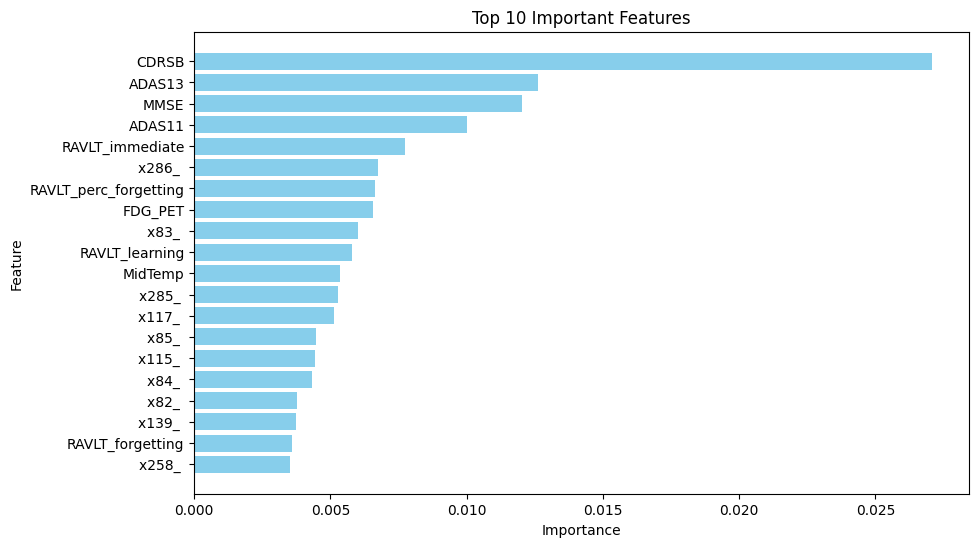

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'features_df' contains the top features and their importances
# Subsetting to the top 10 features for visualization
top_features_df = feature_importances_df.head(20)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_features_df['Feature'], top_features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

In [ ]:
# Assuming 'feature_importances_df' is the DataFrame containing your top features
top_features = feature_importances_df['Feature'].head(20).tolist()

# Directly include identifiable features; adjust this list based on actual one-hot encoded feature mapping
selected_features = ['CDRSB', 'ADAS13', 'MMSE', 'ADAS11', 'RAVLT_immediate', 'RAVLT_perc_forgetting', 'FDG_PET', 'MidTemp', 'RAVLT_learning', 'RAVLT_forgetting']

In [ ]:
# Update the preprocessing to only include selected features
# Assuming 'numeric_features' and 'categorical_features' were defined earlier
selected_numeric_features = [f for f in selected_features if f in numeric_features]
selected_categorical_features = [f for f in selected_features if f in categorical_features]

# Update transformers to only process selected features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selected_numeric_features),
        ('cat', categorical_transformer, selected_categorical_features)
    ]
)

# Fit the preprocessor and transform the training and testing data
X_train_preprocessed = preprocessor.fit_transform(X_train[selected_features])
X_test_preprocessed = preprocessor.transform(X_test[selected_features])

# Fit the Random Forest model to the preprocessed data using only the selected features
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_preprocessed, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predictions
y_pred = rf_model.predict(X_test_preprocessed)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Classification report for detailed analysis
print(classification_report(y_test, y_pred))


Accuracy: 0.7125
Precision: 0.6065913796348579
Recall: 0.602081081081081
Confusion Matrix:
[[21  0  0  3  0]
 [ 0 34  2  1  3]
 [ 0  0 15 22  0]
 [ 2  0  4 44  0]
 [ 0  8  1  0  0]]
              precision    recall  f1-score   support

          AD       0.91      0.88      0.89        24
          CN       0.81      0.85      0.83        40
        EMCI       0.68      0.41      0.51        37
        LMCI       0.63      0.88      0.73        50
         SMC       0.00      0.00      0.00         9

    accuracy                           0.71       160
   macro avg       0.61      0.60      0.59       160
weighted avg       0.69      0.71      0.69       160



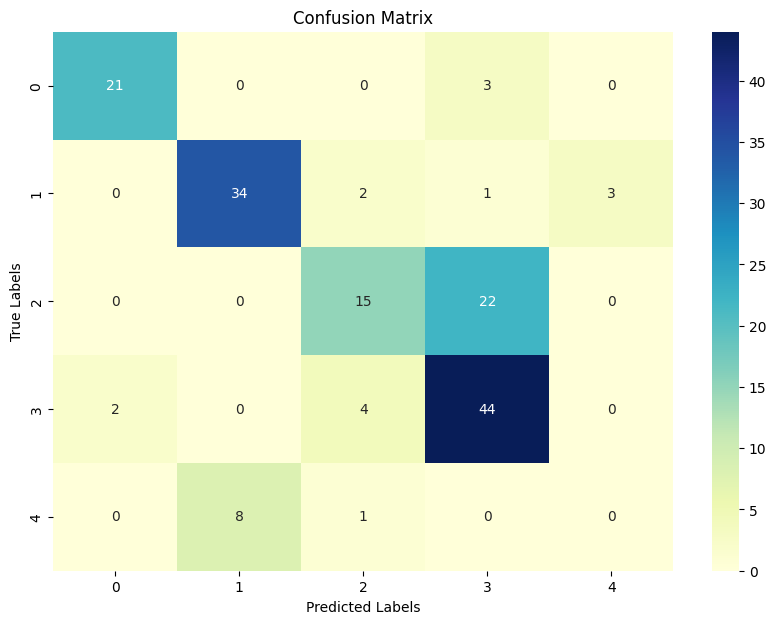

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Using Seaborn to plot a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


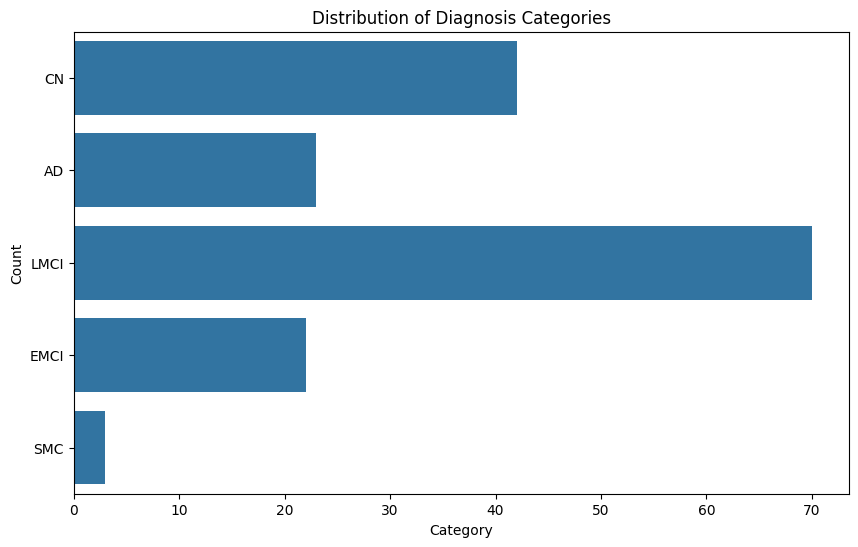

In [ ]:
# Distribution of Diagnosis Categories
plt.figure(figsize=(10, 6))
sns.countplot(y_pred)
plt.title('Distribution of Diagnosis Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()
